# TP1 - Détection de points d'intêret

Le but de ce TP est, dans un premier temps, d'implémenter plusieurs méthodes de détections des coins et de déterminer l'influence des différents paramètres qui régissent ces méthodes. Puis, dans un second temps, de travailler sur divers descripteurs en comparant leurs performances.

In [2]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy.ndimage as ndi
import scipy.signal as sig
from skimage.io import imread,imshow
from skimage.color import rgb2gray
from skimage.transform import rotate
from matplotlib import patches

import cv2



'''
from scipy import signal as sig,ndimage
import numpy as np
from skimage.io import imread,imshow
from skimage.color import rgb2gray 
'''

'\nfrom scipy import signal as sig,ndimage\nimport numpy as np\nfrom skimage.io import imread,imshow\nfrom skimage.color import rgb2gray \n'

In [15]:
from harris import *

## Exercice 1 - Détection de points d'intérêts

Dans cet exercice, nous allons implémenter plusieurs méthodes de détection de points d'intérêt.

### 1 - Détecteur de Harris


### Avec une fenêtre de pondération rectangulaire

L'idée de cette méthode repose sur l'utilisation d'une petite fenêtre rectangulaire que l'on déplace sur l'ensemble de l'image. À chaque itération, ie déplacement de la fenêtre, nous évaluons l'homogénéité globale de l'intensité sur la fenêtre grâce à une matrice M tq :

$$M =
\begin{pmatrix}
\sum I_x^2 & \sum I_xI_y\\
\sum I_xI_y & \sum I_y^2 \\
\end{pmatrix}
=
R^{-1}
\begin{pmatrix}
\lambda_1 & 0\\
0 & \lambda_2 \\
\end{pmatrix}
\qquad(1)$$

L'objectif final est de calculer C, tq :
$$C=det(M)-k*Trace(M)^2 \qquad(2)$$

Ce C permet de comparer les valeurs propres $\lambda$ de la matrice M sans avoir besoin de les calculer. 

Solution adoptée :
Nous commencons par afficher l'image en noire et blanc afin de travailler sur les intensités des pixels. Puis, nous calculons les dérivées en x et en y de l'intensité de chaque pixel de l'image. Pour cela nous utilisons le filtre de Sobel. Nous convoluons le filtre à notre image :
$$
I_x =
\begin{pmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1 
\end{pmatrix}
* 
Image \\
$$
$$
I_y =
\begin{pmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1 
\end{pmatrix}
* 
Image
$$

Ensuite, nous calculons les coefficients $I_x^2$, $I_y^2$ et $I_xI_y$ qui sont nécessaires afin d'obtenir la matrice $M$. 

Enfin, nous parcourons l'ensemble de l'image avec une fenêtre (pour l'instant nous avons choisi une taille $3p*3p$) par pas de 1 pixel. À chaque itération, nous calculons les 4 coefficients de la matrice $M$. Puis nous déterminons $C$ à l'aide de l'équation $2$ après avoir calculé le déterminant et la trace de $M$. Pour l'instant, nous choisissons $k=0,04$ (nous étudierons son influence par la suite). 
Pour identifier les points d'intérêt, nous testons $C$. Si $C>5$ (pour $C>0$, il y a beaucoup trop de points d'intérêt), nous marquons le pixel en rouge sur l'image. Voici l'image que nous obtenons :

In [16]:
img = "M1.JPG"

coins_brute,count_rect = detection_harris_rectangle(img,0)
imshow(coins_brute)


NameError: name 'harris_response' is not defined

### Commentaire :

...

### Fonction pour la suppression des non-maxima locaux

In [9]:
img_path = "M1.JPG"

img = imread(img_path)

img_suppr,c_supr_rect= sup_non_maxima_optimized(coins_brute,img_path)

### Affichage de la différence avec/sans maxima locaux

img_suppr = img - img_suppr
img_suppr[img_suppr < 0] = 0
img_suppr[img_suppr > 0] = 255

coins_brute = img - coins_brute
coins_brute[coins_brute < 0] = 0
coins_brute[coins_brute > 0] = 255

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(coins_brute, cmap='gray')
ax1.set_title('avant suppression des non-maxima locaux')
ax2.imshow(img_suppr, cmap='gray')
ax2.set_title('après suppression des non-maxima locaux')
plt.show()

NameError: name 'coins_brute' is not defined

### Commentaire :

...

### Avec une fenêtre de pondération gaussienne

In [10]:
def detection_harris_gauss_optimized(img_path, rot,window_size=3,k=0.04,sigma=2):
    img = imread(img_path)
    if rot != 0:
        img = ndi.rotate(img, rot, reshape=False)
    img_gray = rgb2gray(img)

    width = np.shape(img_gray)[1]  # largeur et hauteurs de l'image
    height = np.shape(img_gray)[0]
   
    Ix, Iy = np.gradient(img_gray)  # gradients dans les directions x et y 

    Ix2 = np.square(Ix)  # les trois calculs pour la matrice M
    Iy2 = np.square(Iy)
    IxIy = (Ix * Iy)

    
    kernel_size = window_size # Adjust the kernel size as needed
    gaussian_kernel = np.zeros((kernel_size, kernel_size))
    for y in range(kernel_size):
        for x in range(kernel_size):
            gaussian_kernel[y, x] = 1 / (2 * np.pi * sigma ** 2) * np.exp(
                -((x - (kernel_size - 1) / 2) ** 2 + (y - (kernel_size - 1) / 2) ** 2) / (2 * sigma ** 2))

    # Convolve the matrices with the Gaussian kernel
    Ix2gauss = sig.convolve2d(Ix2, gaussian_kernel, boundary='fill', mode='same')
    Iy2gauss = sig.convolve2d(Iy2, gaussian_kernel, boundary='fill', mode='same')
    IxIygauss = sig.convolve2d(IxIy, gaussian_kernel, boundary='fill', mode='same')

    img_copy_for_corners = np.copy(img)  # on créer une copie pour ne pas altérer l'image d'origine
    count = 0

    deter = (Ix2gauss * Iy2gauss) - (IxIygauss ** 2)
    trace = Ix2gauss + Iy2gauss
    C = deter - k * (trace ** 2)  # calcul du critère pour le seuillage des points d'intérêts
    threshold = 0.01 * C.max()  # on seuil la réponse pour avoir les points d'intérêts
    img_copy_for_corners[C > threshold] = [255, 0, 0]  # on met en rouge les points d'intérêts
    count = np.sum(C > threshold)

    return img_copy_for_corners, count


In [11]:
coins_brute_gauss,count_gauss= detection_harris_gauss_optimized(img,0)
imshow(coins_brute_gauss)

OSError: Cannot understand given URI: array([[[183, 196, 215],
        [126, 142, 167],
       ....

### Commentaire :

...

### Avec suppression :

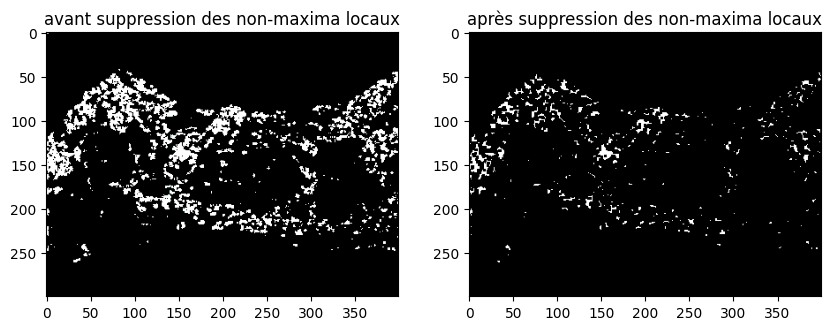

In [27]:
img_path = "M1.JPG"

img = imread(img_path)

img_suppr_gauss,c_supr_gauss = sup_non_maxima_optimized(coins_brute_gauss,img_path)

### Affichage de la différence avec/sans maxima locaux

img_suppr_gauss = img - img_suppr_gauss
img_suppr_gauss[img_suppr_gauss < 0] = 0
img_suppr_gauss[img_suppr_gauss > 0] = 255

coins_brute_gauss = img - coins_brute_gauss
coins_brute_gauss[coins_brute_gauss < 0] = 0
coins_brute_gauss[coins_brute_gauss > 0] = 255

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(coins_brute_gauss, cmap='gray')
ax1.set_title('avant suppression des non-maxima locaux')
ax2.imshow(img_suppr_gauss, cmap='gray')
ax2.set_title('après suppression des non-maxima locaux')
plt.show()

### Commentaire :

...

### Avec une matrice hessienne :

In [28]:
def detection_hessienne(img_path, rot):
    img = imread(img_path)
    if rot != 0:
        img = ndi.rotate(img, rot, reshape=False)

    img_gray = rgb2gray(img)

    Ix, Iy = np.gradient(img_gray)  # gradient in x and y directions
    Ixx,Ixy = np.gradient(Ix)
    Iyx,Iyy = np.gradient(Iy)

    img_copy_for_corners = np.copy(img)
    count = 0

    height, width = img_gray.shape

    det_H = Ixx * Iyy - Ixy* Iyx

    C = det_H

    threshold = 0.01 * C.max()  # seuil

    for x in range(height):
        for y in range(width):
            if C[x, y] > threshold:
                img_copy_for_corners[x, y] = [255, 0, 0]
                count += 1

    return img_copy_for_corners, count

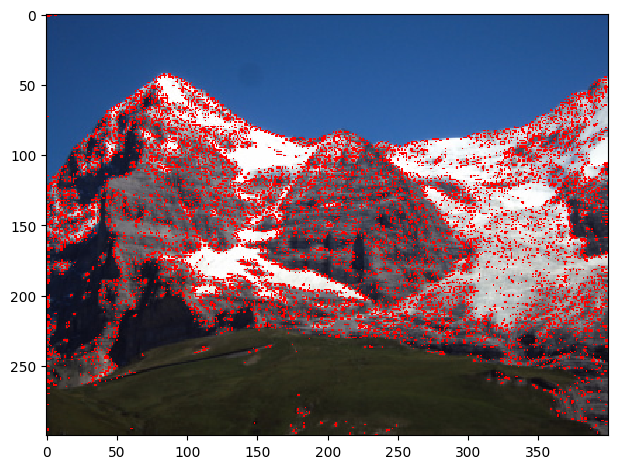

In [44]:
img_path = "M1.JPG"

coins_brute_hess,count_hess = detection_hessienne(img_path,0)
imshow(coins_brute_hess)

### Commentaire :

...

### Avec suppression :

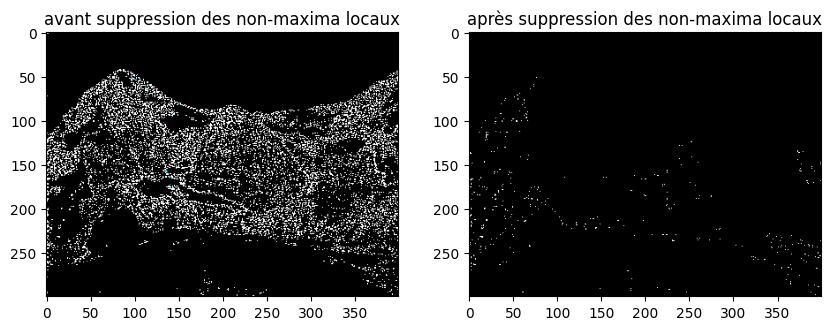

In [45]:
img_path = "M1.JPG"

img = imread(img_path)

img_suppr_hess,c_supr_hess = sup_non_maxima_optimized(coins_brute_hess,img_path)

### Affichage de la différence avec/sans maxima locaux


""" # On récupère les coordonnées des pixels rouges
red_pixels = np.where(np.all(coins_brute_hess == [255, 0, 0], axis=-1))

# On crée une image noire de la même taille que coins_brute_hess
black_img = np.zeros_like(coins_brute_hess)

# On met en blanc les pixels rouges de coins_brute_hess dans black_img
black_img[red_pixels] = [255, 255, 255]

# On affiche l'image
plt.imshow(black_img)
plt.show() """

img_suppr_hess = img - img_suppr_hess
img_suppr_hess[img_suppr_hess < 0] = 0
img_suppr_hess[img_suppr_hess > 0] = 255

coins_brute_hess = img - coins_brute_hess
coins_brute_hess[coins_brute_hess < 0] = 0
coins_brute_hess[coins_brute_hess > 0] = 255

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(coins_brute_hess, cmap='gray')
ax1.set_title('avant suppression des non-maxima locaux')
ax2.imshow(img_suppr_hess, cmap='gray')
ax2.set_title('après suppression des non-maxima locaux')
plt.show()

### Commentaire :

...

### Influence du type de fenêtre de pondération, de sa taille ainsi que du paramètre k dans la détection de point d’intérêt.

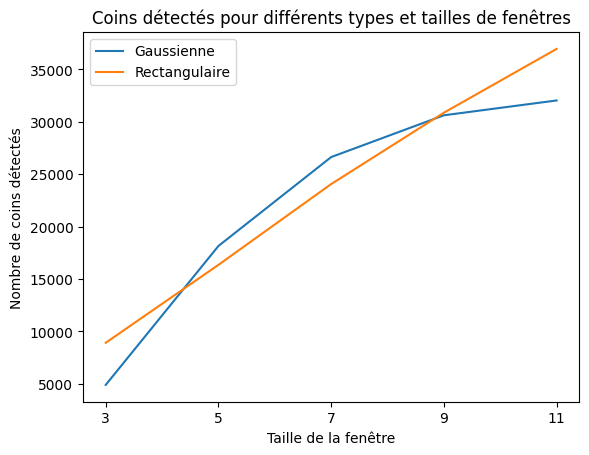

In [65]:
# Définition d'un ensemble de types et de tailles de fenêtres à tester
types_fenetre = ['gaussian', 'uniform', 'hess']
tailles_fenetre = [3, 5, 7, 9, 11]

# Initialisation d'une liste pour stocker le nombre de coins détectés pour chaque type et taille de fenêtre
num_corners_gaussian = []
num_corners_uniform = []
#num_corners_hess = []

# Boucle sur tous les types et tailles de fenêtres
for window_type in types_fenetre:
    if window_type == 'gaussian':
        func = detection_harris_gauss_optimized
        num_corners = num_corners_gaussian
    #elif window_type == 'hess':
    #    func = detection_hessienne
    #    num_corners = num_corners_hess
    else:
        func = detection_harris_rectangle
        num_corners = num_corners_uniform
    for window_size in tailles_fenetre:
        # Exécution de l'algorithme de détection de coins avec le type et la taille de fenêtre actuels
        img_corners, num_detected = func(img, 0, window_size)
        # Stockage du nombre de coins détectés
        num_corners.append(num_detected)

# Tracé du nombre de coins détectés en fonction du type et de la taille de fenêtre
fig, ax1 = plt.subplots()
ax1.plot(num_corners_gaussian, label='Gaussienne')
ax1.plot(num_corners_uniform, label='Rectangulaire')
#ax1.plot(num_corners_hess, label='Hessienne')
ax1.set_xticks(range(len(tailles_fenetre)))
ax1.set_xticklabels(tailles_fenetre)
ax1.set_xlabel('Taille de la fenêtre')
ax1.set_ylabel('Nombre de coins détectés')
ax1.set_title('Coins détectés pour différents types et tailles de fenêtres')
ax1.legend()

plt.show()

### Commentaire :
On constate que globalement, pour tous les types de fenêtre, le nombre de coins détectés augmente avec la taille de la fenêtre. 
Comment expliquer cela ?
Il semble que cette variation dépende du type d'image que l'on traite. En effet, ici nous avons affaire à une image de montagne. Ainsi, les coins principaux qui sont les arrêtes de la montagnes sont relativement gros et donc plus facilement détectables avec de grandes fenêtres. Si on réalise le même test avec une autre image ou les coins sont plus petits, nous ne devrions pas avoir le même type de variation

 `---> à vérifier`

#### 1) Influence du paramètre k

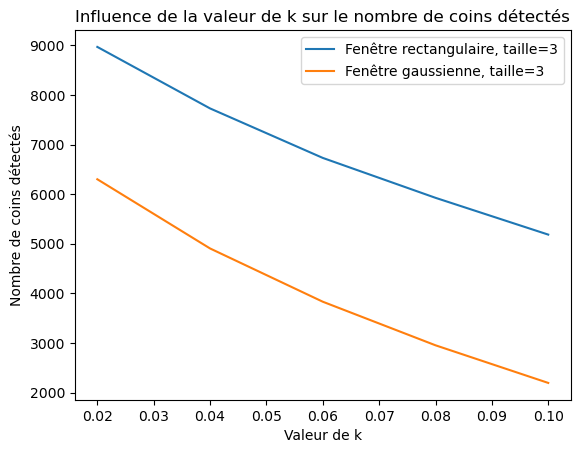

In [151]:
# Différentes valeurs de k à tester
k_values = [0.02, 0.04, 0.06, 0.08, 0.1]

num_corners_rectangular = []
num_corners_gaussian = []

# Boucle sur chaque valeur de k
for k in k_values:
    # Détection des coins avec une fenêtre rectangulaire pour les différents k
    img_corners, num_detected = detection_harris_rectangle(img, 0, 3, k)
    num_corners_rectangular.append(num_detected)
    # Détection des coins avec une fenêtre gaussienne cette fois
    img_corners, num_detected = detection_harris_gauss_optimized(img, 0, 3, k)
    num_corners_gaussian.append(num_detected)

# Tracé du nombre de coins détectés pour chaque type de fenêtre en fonction de la valeur de k
plt.plot(k_values, num_corners_rectangular, label='Fenêtre rectangulaire, taille=3')
plt.plot(k_values, num_corners_gaussian, label='Fenêtre gaussienne, taille=3')
plt.legend()
plt.xlabel('Valeur de k')
plt.ylabel('Nombre de coins détectés')
plt.title('Influence de la valeur de k sur le nombre de coins détectés')
plt.show()


### Commentaire :

Le résultat est cohérent. En effet, le paramètre k détermine la sélectivité de notre détecteur. Ainsi, plus k est grand et plus le détecteur est sélectif et donc moins il détect de points d'intérêt.

### Rotation de l'image

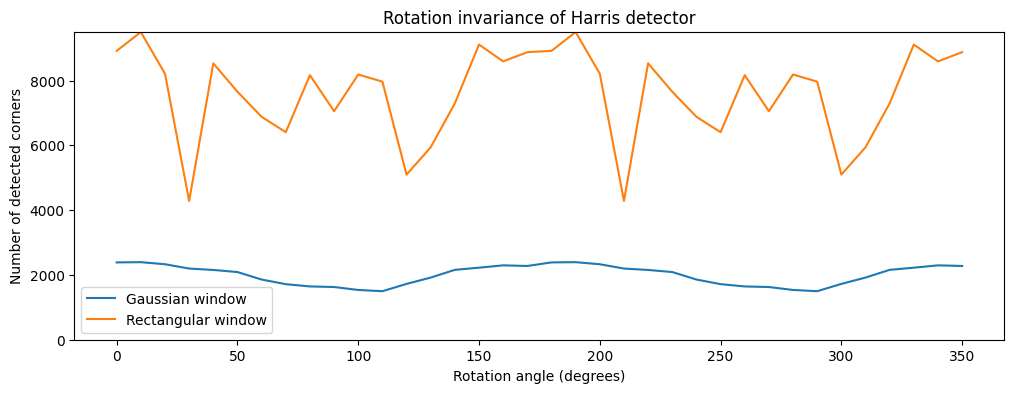

In [66]:

# Define the rotation angles to test
angles = np.arange(0, 360, 20)

# Initialize a list to store the number of detected corners for each angle
num_corners_gauss = []
num_corners_rect = []
num_corners_hess = []

# Apply the Harris detector for each angle and store the number of detected corners
for angle in angles:
    _, num_detected_gauss = detection_harris_gauss_optimized(img, angle,sigma=2)
    num_corners_gauss.append(num_detected_gauss)
    _, num_detected_rect = detection_harris_rectangle(img, angle)
    num_corners_rect.append(num_detected_rect)
    _, num_detected_hess = detection_harris_hessienne(img, angle)
    num_corners_hess.append(num_detected_hess)

# Plot the number of detected corners as a function of the rotation angle
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(angles, num_corners_gauss, label='Gaussian window')
ax.plot(angles, num_corners_rect, label='Rectangular window')
ax.plot(angles, num_corners_hess, label='Hessian')
ax.set_xlabel('Rotation angle (degrees)')
ax.set_ylabel('Number of detected corners')
ax.set_title('Rotation invariance of Harris detector')
ax.legend()

max_value = max(max(num_corners_gauss), max(num_corners_rect), max(num_corners_hess))
ax.set_ylim([0, max_value + 10])

plt.show()


### Commentaire :

Comme nous pouvions nous y attendre, nous observons que le détecteur de Harris est invariant par rotation avec l'utilisation d'une fenêtre Gaussienne. En revanche, ce n'est pas du tout le cas avec la fenêtre rectangulaire dont le nombre de points d'intérêt détectés varie fortement avec l'angle de rotation.

Pourquoi cela ?

Avec la fenêtre gaussienne, les gradients d'intensité dans toutes les directions sont pris en compte de manière égale. La fenêtre gaussienne étale les variations d'intensité dans toutes les directions ce qui entraîne une invariance par rotation de la détection. Mais pour la fenêtre rectangulaire, aucune pondération n'est effectuée selon la direction, ie lorsque l'image est tournée, les gradients d'intensité changent.

## 2 - Détecteur FAST

In [4]:
from fast import *

## Méthode 1 - méthode itérative

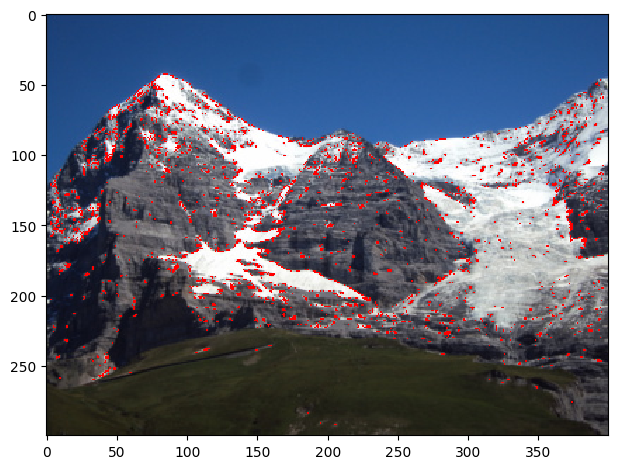

In [10]:
''' TEST de la méthode FAST '''

img_FAST, _ = fast_1("M1.JPG", 0.09, 12, 0)

imshow(img_FAST)

## Méthode 2 - méthode avec filtres

Il existe également des méthodes de Machine Learning qui permette d'optimiser encore d'avantage la méthode FAST [3]

## Suppression des non-maxima locaux pour FAST

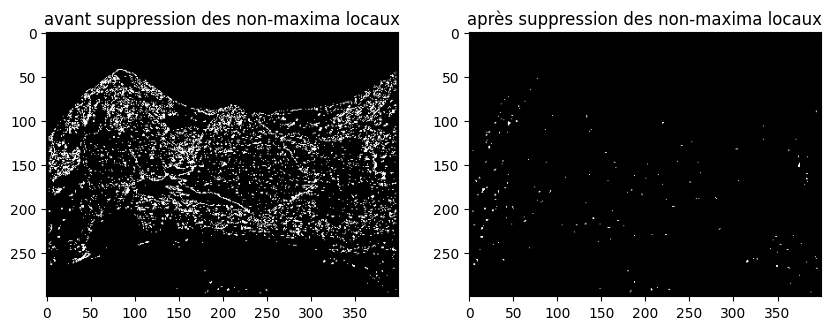

In [53]:

image = imread("M1.JPG")

img_FAST, _ = fast_1("M1.JPG", 0.05, 12, 0)
new_FAST_image,c = sup_non_maxima_optimized(img_FAST, "M1.JPG")


### Affichage de la différence avec/sans maxima locaux

new_FAST_image = image - new_FAST_image
new_FAST_image[new_FAST_image < 0] = 0
new_FAST_image[new_FAST_image > 0] = 255

img_FAST = image - img_FAST
img_FAST[img_FAST < 0] = 0
img_FAST[img_FAST > 0] = 255

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img_FAST, cmap='gray')
ax1.set_title('avant suppression des non-maxima locaux')
ax2.imshow(new_FAST_image, cmap='gray')
ax2.set_title('après suppression des non-maxima locaux')
plt.show()


## FAST : Rotation de l'image

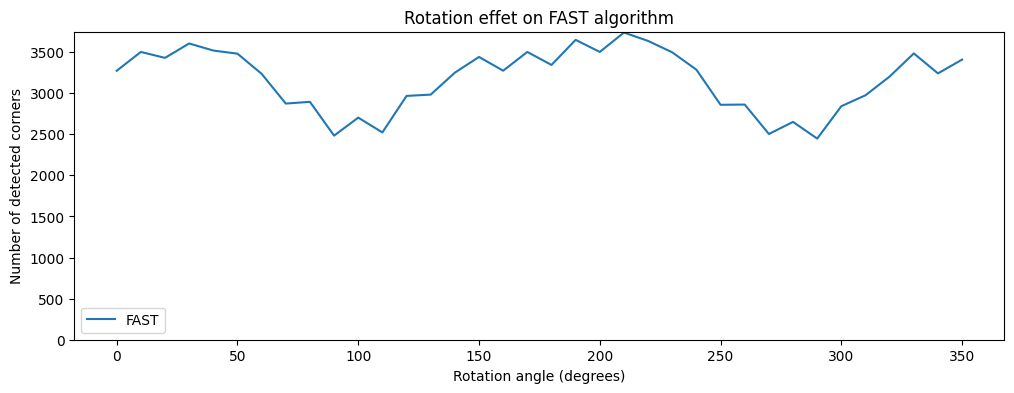

Le nombre max de détection est : 3737 ; le nombre min de détection est : 2447


In [74]:
# Définition des angles de rotation à tester
angles = np.arange(0, 360, 10)

# Initialiser une liste pour stocker le nombre de coins détectés pour chaque angle
num_corners_fast = []

# Appliquer le détecteur FAST pour chaque angle et enregistrer le nombre de coins détectés.
for angle in angles:
    _, num_detected_fast = fast_1(img, 0.1, 12, angle)
    num_corners_fast.append(num_detected_fast)

# Tracer le nombre de coins détectés en fonction de l'angle de rotation
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(angles, num_corners_fast, label='FAST')
ax.set_xlabel('Rotation angle (degrees)')
ax.set_ylabel('Number of detected corners')
ax.set_title('Rotation effet on FAST algorithm')
ax.legend()

max_value = max(num_corners_fast)
min_value = min(num_corners_fast)

ax.set_ylim([0, max_value + 10])

plt.show()

print("Le nombre max de détection est :", max_value, "; le nombre min de détection est :", min_value)

### Commentaire :

Nous pouvons constater que le détecteur FAST n'est pas invariant par rotation. Le nombre de détection s'étend de 2447 pour le minimum à 3737 pour le maximum. Il y a donc 1290 détections de différence.

FAST n'est pas invariant par rotation car c'est une méthode qui repose sur des comparaisons locales d'intensité des pixels. 

La méthode FAST ne prend pas en compte l'orientation des points d'intérêt. Si on fait tourner l'image, les variations locales de l'intensité qui étaient significatives avant la rotation peuvent ne plus l'être après la rotation. De plus, FAST repose sur une disposition spécifique des pixels dans le cercle de test. Lorsque l'image est tournée, cette disposition peut changer, affectant ainsi les comparaisons locales.



## 3 - Comparaison FAST/Harris

In [5]:
from comparaison import *

### Comparaison des points d'intérêt

Pour réaliser cette comparaison, nous proposons deux méthodes :
* Tout d'abord, nous réaliserons une simple soustraction entre les deux images afin d'afficher uniquement les point d'intérêt qui ne sont pas communs aux deux détections.
* Puis, nous comparerons le quotient du nombre de points d'intérêt post suppression des non-maxima locaux sur le nombre de points d'intérêt total, ce qui devrait nous donner un indice intéressant sur la précision des méthodes (plus le quotient est proche de 1, plus la méthode est précise, plus il est proche de 0, le moins elle l'est). 

### Méthode 1 

In [4]:

img_points = comp_soustraction( "M1.JPG" )

# Affichage des points d'intérêts uniques à chaque méthode
fig, ax = plt.subplots()
#ax.imshow(img)
ax.imshow(img_points, alpha=0.5)
ax.set_title('Points of interest detected by Harris (green) and FAST (red)')
ax.legend(handles=[patches.Patch(color='green', label='Harris'), patches.Patch(color='red', label='FAST')])
plt.show()


TypeError: 'numpy.ndarray' object is not callable

### Commentaire :

On constate que les points spécifiques à FAST sont plus étalés géographiquement. La méthode FAST détecte les crêtes de la montagnes avec plus de précision. On peut s'avancer à dire que FAST détecte plus de points d'intérêt que Harris. Globalement les seuls endroits où Harris détecte des points que FAST n'a pas détecté sont les non-maxima locaux, ie des petites zones où Harris détecte une grande quantité de points d'intérêt.

### Méthode 2

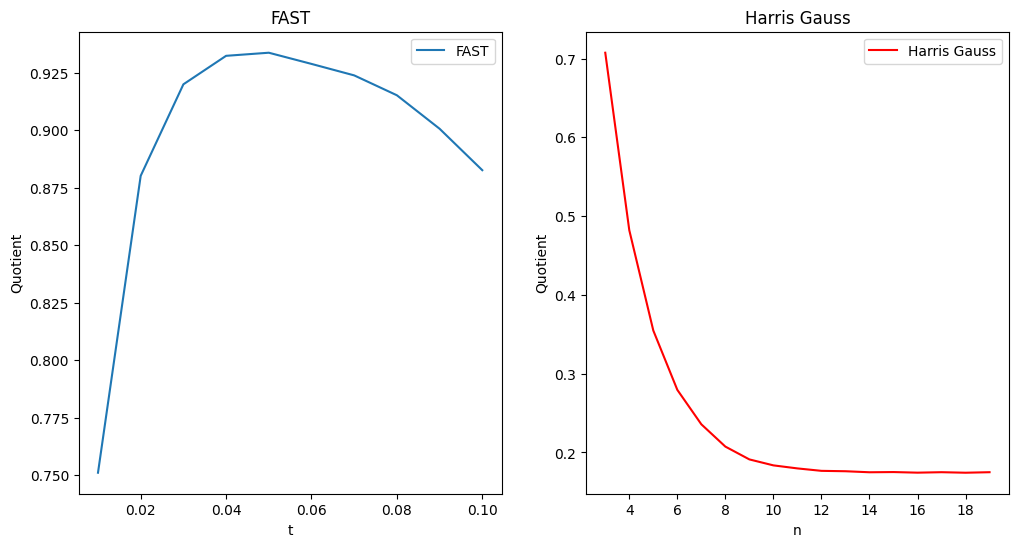

In [20]:

# Load the image
img = imread("M1.JPG")

# Define the parameters for FAST and Harris Gauss
radius_FAST = 12
threshold_Harris_Gauss = 0.04
sigma_Harris_Gauss = 2

# Define the range of k values to test
k_fast_values = np.arange(0.01, 0.11, 0.01)
n_harris_values = np.arange(3, 20, 1)

# Initialize lists to store the quotient of the number of points of interest post suppression of non-maxima locals to the total number of points of interest for FAST and Harris Gauss
quotient_FAST = []
quotient_Harris_Gauss = []

# Loop through the k values and calculate the quotient for each method
for k_f in k_fast_values:
    img_FAST, count_fast = fast_1("M1.JPG", k_f, radius_FAST, 0)
    # Suppress non-maxima locals
    _, count_suppr_fast = sup_non_maxima_optimized(img_FAST, "M1.JPG")
    # Count the number of points of interest for each method
    num_FAST = count_fast
    # Count the number of points of interest post suppression of non-maxima locals for each method
    num_FAST_post_sup = count_fast - count_suppr_fast
    # Calculate the quotient for each method
    quotient_FAST.append(num_FAST_post_sup / num_FAST)
    

for n_h in n_harris_values :
    img_Harris_Gauss, count_harris = detection_harris_gauss_optimized("M1.JPG", 0, n_h, 0.04, 2)
    # Suppress non-maxima locals
    _, count_suppr_harris = sup_non_maxima_optimized(img_Harris_Gauss, "M1.JPG")
    # Count the number of points of interest for each method
    num_Harris_Gauss = count_harris
    # Count the number of points of interest post suppression of non-maxima locals for each method
    num_Harris_Gauss_post_sup = count_harris - count_suppr_harris
    # Calculate the quotient for each method
    quotient_Harris_Gauss.append(num_Harris_Gauss_post_sup / num_Harris_Gauss)


# Plot the results as two curves side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Plot the FAST curve on the first subplot
ax1.plot(k_fast_values, quotient_FAST, label='FAST')
ax1.set_xlabel('t')
ax1.set_ylabel('Quotient')
ax1.set_title('FAST')
ax1.legend()

# Plot the Harris Gauss curve on the second subplot
ax2.plot(n_harris_values, quotient_Harris_Gauss, label='Harris Gauss', color='red')
ax2.set_xlabel('n')
ax2.set_ylabel('Quotient')
ax2.set_title('Harris Gauss')
ax2.legend()

plt.show()

### Commentaire :

On observe que pour la méthode FAST (avec n fixé à 12), le quotient est globalement assez proche de 1, ce qui signifie que peu de points d'intérêt sont éliminés, ce qui implique que la méthode est précise dans sa sélection des points d'intérêt. La croissance du quotient pour les premières valeurs de t est dûe au fait que pour des petites valeurs de t, FAST est moins sélective puisque l'intervalle de sélection est plus large. Ainsi, il y aura plus de points d'intérêt sélectionnés et donc plus de non-maxima locaux.

En revanche, pour Harris (avec k fixé à 0.04), on constate que le quotient est assez faible, ce qui signifie que beaucoup de points ont été supprimés par la fonction de suppression des non-maxima locaux. Ainsi, la fonction Harris est beaucoup moins sélective. Pour 1 "vrai" point d'intérêt, elle en détecte une multitude. D'ailleurs, cela se voit visuellement sur l'image où l'on affiche les points d'intérêt en rouge. On observe sur cette image beaucoup de conglomérats de points, beaucoup plus que sur l'image résultante du traitement par FAST. La décroissance du quotient avec l'augmentation de n est dûe au fait que, avec n croissant, il y a beaucoup plus de point d'intérêt détectés (comme nous avons pu l'observer précédemment) et une plus grande partie de ces points sont des non maxima locaux. 

## Comparaison aux méthodes déjà implémentées

### Comparaison en terme de vitesse d'exécution

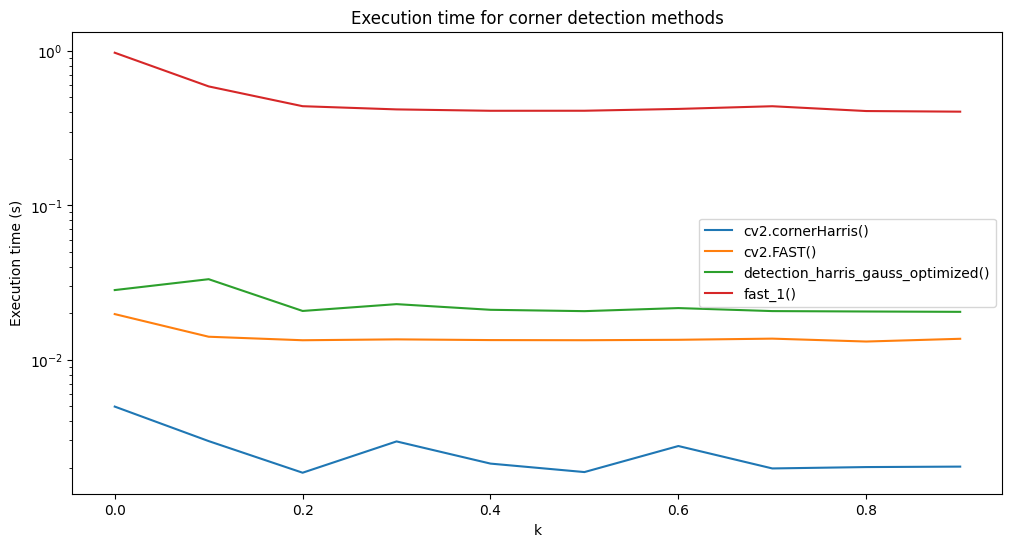

In [24]:

import time
from scipy.signal import convolve2d
from scipy.ndimage import maximum_filter

# Load the image
img = plt.imread("M1.JPG")

# Define the parameters for FAST and Harris Gauss
threshold_FAST = 0.05
radius_FAST = 12
threshold_Harris_Gauss = 0.04
sigma_Harris_Gauss = 2

# Define the range of k values to test
k_values = np.arange(0, 1, 0.1)

# Initialize lists to store the execution times for each method
time_cv2_Harris = []
time_cv2_FAST = []
time_Harris_Gauss = []
time_FAST = []

# Loop through the k values and calculate the execution time for each method
for k in k_values:
    # Detect the points of interest using cv2.cornerHarris() and cv2.FAST()
    start_time = time.time()
    dst_cv2_Harris = cv2.cornerHarris(np.uint8(rgb2gray(img)*255), 2, 3, k, cv2.BORDER_DEFAULT)
    time_cv2_Harris.append(time.time() - start_time)

    start_time = time.time()
    #dst_cv2_FAST = cv2.FastFeatureDetector_create(int(threshold_FAST*100))(np.uint8(rgb2gray(img)*255), None)
    fast = cv2.FastFeatureDetector_create(int(threshold_FAST*100))
    kp_FAST = fast.detect(np.uint8(rgb2gray(img)*255), None)
    dst_cv2_FAST = np.zeros_like(img)
    dst_cv2_FAST = cv2.drawKeypoints(img, kp_FAST, dst_cv2_FAST, color=(255,0,0))
    time_cv2_FAST.append(time.time() - start_time)

    # Detect the points of interest using detection_harris_gauss_optimized() and fast_1()
    start_time = time.time()
    img_Harris_Gauss, _ = detection_harris_gauss_optimized("M1.JPG", 0, 3, k, sigma_Harris_Gauss)
    time_Harris_Gauss.append(time.time() - start_time)

    start_time = time.time()
    img_FAST, _ = fast_1("M1.JPG", k, radius_FAST, 0)
    time_FAST.append(time.time() - start_time)



# Plot the results as a curve
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(k_values, time_cv2_Harris, label='cv2.cornerHarris()')
ax.plot(k_values, time_cv2_FAST, label='cv2.FAST()')
ax.plot(k_values, time_Harris_Gauss, label='detection_harris_gauss_optimized()')
ax.plot(k_values, time_FAST, label='fast_1()')
ax.set_xlabel('k')
ax.set_ylabel('Execution time (s)')
ax.set_title('Execution time for corner detection methods')
ax.legend()
ax.set_yscale('log')
plt.show()


### Commentaire :

Comme nous pouvions nous en douter, les fonctions d'open cv sont beaucoup plus performante que les notres, d'environ un facteur 10 (voir plus pour FAST).

# Exercice 2 : Description et matching des points d'intérêt

In [17]:
# Nouvelle fonction FAST qui renvoie un vecteur de points d'intérêt

def fast_for_matching(image_path: np.ndarray, t: float, n: int, rot: int) -> np.ndarray:
    
    image = imread(image_path)

    if rot != 0 :
        image= ndi.rotate(image,rot, reshape=False)
    img_gray=rgb2gray(image)

    #x,y = neshjrid
    #xN = x +[0,1,2,3,3,3,2,1,0,-1,-2,-3,-3,-3,-2,1]
    #yN = y +[3,3,2,1,0,-1,-2,-3,-3,-3,-2,-1,0,1,2,3]
    #imgN = img.flatten()[xN*img.shape(1)+yN]


    width = np.shape(image)[1] # largeur et hauteurs de l'image
    height = np.shape(image)[0]
    x, y = 0, 0
    vect_pt_interet = []

    img_gray=rgb2gray(image)
    
    img_copy_for_FAST = np.copy(image)

    for x in range(3,height-3): 
        for y in range(3,width-3):
            
            pt_cercle = cercle(x,y)
            I_p0 = img_gray[x][y]

            if compare_Intensity(img_gray, pt_cercle, I_p0, t, n):
                vect_pt_interet.append((x,y))    # on rentre les coordonnées des pt d'intérêt
                                                 # dans un vecteur au lieu de colorer l'image en rouge
            if((y+3)%width == 0):
                break
    
    return(vect_pt_interet)
            


In [18]:
def bloc_descriptor(img_path1, img_path2, taille_bloc ,type_methode : int):


    # récupérer les points d'intérêt (img 1 et 2)

    vect_interet_1 = fast_for_matching(img_path1, 0.09, 12, 0) 
    vect_interet_2 = fast_for_matching(img_path2, 0.09, 12, 0) 
    taille_vect1 = np.shape(vect_interet_1)[0]
    taille_vect2 = np.shape(vect_interet_2)[0]

    # créer n1+n2 vecteurs de bloc (avec n1, n2 = le nombre de points d'intérêt dans img 1 et 2 resp)
    # On stock ces vecteurs sous forme de matrice. Les deux matrices sont vecteurs_de_bloc_1 et 2. Une matrice par image.

    vecteurs_de_bloc_1 = []
    vecteurs_de_bloc_2 = []

    for i in range(taille_vect1):
        (x,y)=vect_interet_1[i]
        intvect1 = [img_gray[x][y],img_gray[x-1][y],img_gray[x+1][y],img_gray[x-1][y-1],img_gray[x+1][y-1],img_gray[x][y-1],img_gray[x][y+1],img_gray[x-1][y+1],img_gray[x+1][y+1]]
        # pour l'instant on observe juste les plus proches voisins
        vecteurs_de_bloc_1.append(intvect1)
    for i in range(taille_vect2):
        (x,y)=vect_interet_2[i]
        intvect2 = [img_gray[x][y],img_gray[x-1][y],img_gray[x+1][y],img_gray[x-1][y-1],img_gray[x+1][y-1],img_gray[x][y-1],img_gray[x][y+1],img_gray[x-1][y+1],img_gray[x+1][y+1]]
        # pour l'instant on observe juste les plus proches voisins
        vecteurs_de_bloc_2.append(intvect2)


    # Suppression des mauvais match : appariement croisé pour chaque pt d'intérêt

    dist1 = []
    dist2 = []
    min_dist1 = []
    min_dist2 = []
    size_vecteurs_bloc_1 = np.shape(vecteurs_de_bloc_1)
    size_vecteurs_bloc_2 = np.shape(vecteurs_de_bloc_2)
    print(size_vecteurs_bloc_1)

    for i in range(size_vecteurs_bloc_1[0]):
        for j in range(size_vecteurs_bloc_2[0]):
            somme = 0
            for k in range(size_vecteurs_bloc_1[1]):
                somme+=np.abs(vecteurs_de_bloc_1[i][k] - vecteurs_de_bloc_2[j][k])
            dist1.append(somme)
        min_dist1.append(np.argmin(dist1)) # On récupère l'indice de la valeur minimum de distance qui pointe vers 
                                           # le point d'intérêt de l'image 2 qui match le point d'intérêt de l'image 1

    for i in range(size_vecteurs_bloc_2[0]):
        for j in range(size_vecteurs_bloc_1[0]):
            somme = 0
            for k in range(size_vecteurs_bloc_2[1]):
                somme+=np.abs(vecteurs_de_bloc_2[i][k] - vecteurs_de_bloc_1[j][k])
            dist2.append(somme)
        min_dist2.append(np.argmin(dist2)) # On récupère l'indice de la valeur minimum de distance qui pointe vers 
                                           # le point d'intérêt de l'image 1 qui match le point d'intérêt de l'image 2
    

    for i in range(len(min_dist1)):
        if(min_dist1[i] != min_dist2[i]):

            del(vect_interet_1[min_dist1[i]])  # On supprime les points d'interet qui ont des mauvais appariements
            del(vect_interet_2[min_dist2[i]])  # des liste vect_interet_1 et 2
            del(vecteurs_de_bloc_1[min_dist1[i]])
            del(vecteurs_de_bloc_2[min_dist2[i]])
            del(min_dist1[i])
            del(min_dist2[i])


    # Appariement des points d'intérêt : 

    appariement = []

    for m in range(len(min_dist1)):
        appariement.append((vect_interet_1[m], vect_interet_2[min_dist1[m]]))

    return appariement
    

    

In [19]:

print(bloc_descriptor("M1.JPG", "M2.JPG", 0, 0))

NameError: name 'img_gray' is not defined

# References

